In [1]:
from preamble import *
from preamble import visits, systeminfo

In [2]:
def linear_baseline(parameters, t):
    a = parameters['slope']
    b = parameters['intercept']
    model = a * t + b
    return model

In [3]:
def transit_model(parameters, t):

    params = batman.TransitParams()
    
    #fixed parameters
    params.per = systeminfo['T_orb (d)'].value                       #orbital period
    params.inc = systeminfo['inclination']                     #orbital inclination (in degrees)
    params.ecc = systeminfo['eccentricity']                    #eccentricity
    params.w = systeminfo['longitude_of_periastron']                     #longitude of periastron (in degrees)

    #variables
    params.t0 = parameters['t0']                      #time of inferior conjunction
    params.rp = parameters['rp_rstar']                      #planet radius (in units of stellar radii)
    params.a = parameters['a_rstar']                       #semi-major axis (in units of stellar radii)
    params.limb_dark = "logarithmic"                     #limb darkening model
    params.u = visits[f'{visit}']['broadband_ldcs']               #limb darkening coefficients [u1, u2]
        
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)       #calculates light curve
    
    return flux

In [4]:
def rampProfile(parameters, t):
    
    """Ramp profile for single directional scan

    And RECTE model parameters: number of traps, trapping coeeficient
    and trap life time

    :param crate: average count rate in electron/second
    :param slope: visit-long slope
    :param dTrap_s: extra trapped slow charges between orbits
    :param dTrap_f: extra trapped fast charges between orbits
    :param trap_pop_s: initially trapped slow charges
    :param trap_pop_f: initially trapped fast charges
    :param tExp: beginning of each exposure
    :param expTime: exposure time
    :returns: observed counts
    :rtype: numpy.array

    """
    crate = parameters['crate']
    slope = parameters['slope']
    trap_pop_s = parameters['trap_pop_s']
    trap_pop_f = parameters['trap_pop_f']
    dTrap_s = parameters['dTrap_s']
    dTrap_f = parameters['dTrap_f']

    tExp = t * 24 * 60 *60 
    tExp = tExp-tExp[0]
    
    cRates = crate * (1 + tExp * slope / 1e7) / expTime
    
    obsCounts = RECTE(
        cRates,
        tExp,
        expTime,
        trap_pop_s,
        trap_pop_f,
        dTrap_s=[dTrap_s],
        dTrap_f=[dTrap_f],
        dt0=[0],
        lost=0,
        mode='scanning')
    
    return obsCounts

In [5]:
def breathing_effect(parameters, t):

    hst_orbital_period = 95.25 # minutes

    phase1 = ((t-t.min()) * 24*60) / hst_orbital_period     # the data point at time "epoch" will be the zero-point; convert int phase by division through period
    phase2 = np.floor(phase1)            # identify integer intervals of phase (where phase is between 0-1, between 1-2, between 2-3 and over 3)
    phase = phase1 - phase2              # make phase be in interval from 0 to 1
    toobig = np.where(phase > 0.5)[0]    # figure out where phase is bigger than 0.5
    if toobig.size > 0:
        phase[toobig] -= 1.0                 # and where it is bigger than 0.5 indeed, subtract one to get to interval [-0.5, 0.5]
    
    a = parameters['breathing_a']
    b = parameters['breathing_b']
    c = parameters['breathing_c']
    d = parameters['breathing_d']
    e = parameters['breathing_e']
    """
    Calculate the value of a fourth-order polynomial: ax^4 + bx^3 + cx^2 + dx + e
    
    Parameters:
    a (float): Coefficient for the x^3 term
    b (float): Coefficient for the x^2 term
    c (float): Coefficient for the x term
    d (float): Constant term
    
    Returns:
    float: The result of the polynomial evaluation
    """

    breathing_model = (a*phase**4 + b*phase**3 + c*phase**2 + d*phase + e)
    return breathing_model

In [6]:
visit = 'F21'
direction = 'Backward'

'Extract exposure times and mid-transit times from the dictionary'
predicted_T0 = visits[f'{visit}']['T0 (BJD_TDB)']
expTime = visits[f'{visit}']['exp (s)'].value/2.0

'Read WFC3 spectral data'
trimmed_r = read_rainbow(f'../data/{visit}_{direction}_trimmed.rainbow.npy').bin(R=30)
img_date = trimmed_r.time.value

  0%|          | 0/162 [00:00<?, ?it/s]

In [7]:
def residual(parameters):

    rainbow = trimmed_r
    t = rainbow.time.value
    flux = rainbow.flux
    wavelength = rainbow.wavelength.value
    unc = rainbow.uncertainty
    
    nanmask = ~np.isnan(t)
    t = t[nanmask]
        
    residual = 0    
    for j in range(len(wavelength)):
        transit_model = 
        model = transit_model * rampProfile(parameters, t) * breathing_effect(parameters, t)
        y = flux[j,:][nanmask]*0.05
        err = unc[j,:][nanmask]
        residual += (y - model)/err

    # Check for NaNs in the residuals and handle them
    if np.any(np.isnan(residual)):
        raise ValueError("NaNs encountered in residuals.")

        return np.inf * np.ones_like(y)
    
    else:
        return residual

In [38]:
################################################################
p = lmfit.Parameters()
# RECTE Params
for j in range(len(wavelength)):
    p.add(f'slope_{j}', value=0, min=-10, max=0, vary=True)
p.add('trap_pop_s', value=0, min=0, max=1000, vary=True)
p.add('trap_pop_f', value=0, min=0, max=1000, vary=True)
p.add('dTrap_f', value=0, min=0, max=1000, vary=True)
p.add('dTrap_s', value=0, min=0, max=1000, vary=True)
# Transit Params
p.add('t0', value=predicted_T0.value, min=predicted_T0.value-0.02,max=predicted_T0.value+0.02,vary=True)
p.add('rp_rstar', value=0.045, min=0.042, max=0.055, vary=True)
p.add('a_rstar', value=17.5, min=16.5, max=18.5, vary=True)
# Breathing effect parameters
p.add('breathing_a', value=0, vary=True)
p.add('breathing_b', value=0, vary=True)
p.add('breathing_c', value=0, vary=True)
p.add('breathing_d', value=0, vary=True)
p.add('breathing_e', value=1, vary=True)

if direction == 'Forward':
    scanDirect = np.zeros_like(img_date)
if direction == 'Backward':
    scanDirect = np.ones_like(img_date)

NameError: name 'wavelength' is not defined

In [9]:
'Calculate the white light curve'
dw = np.nanmedian(trimmed_r.wavelength.value[1:]-trimmed_r.wavelength.value[:-1])
white_light_curve = np.nansum(trimmed_r.flux*dw, axis=0)
uncertainty = np.sqrt(np.nansum((trimmed_r.uncertainty**2*dw), axis=0))
relative_uncertainty = uncertainty/white_light_curve
rel_err = np.clip(relative_uncertainty, 100e-6, 0.1)

data_flux = white_light_curve/len(trimmed_r.wavelength.value) #dividing by the length of the wavelength array to arrive at a more realistic value of electron counts that will maybe play nicer with RECTE
data_err = rel_err*data_flux

p.add('crate', value=np.nanmean(data_flux), min = 1e4, vary=True)

In [10]:
################################################################
'SET UP AND RUN LMFIT MINIMIZER' ###############################
minimizer = lmfit.Minimizer(residual, p)
result = minimizer.minimize()
print(result.params)

Parameters([('slope', <Parameter 'slope', value=-3.357782297621611, bounds=[-10:5]>), ('trap_pop_s', <Parameter 'trap_pop_s', value=23.562194992672758, bounds=[0:1000]>), ('trap_pop_f', <Parameter 'trap_pop_f', value=712.8983143195071, bounds=[0:1000]>), ('dTrap_f', <Parameter 'dTrap_f', value=847.2635183467517, bounds=[0:1000]>), ('dTrap_s', <Parameter 'dTrap_s', value=992.087994936886, bounds=[0:1000]>), ('t0', <Parameter 't0', value=2459455.9918551366, bounds=[2459455.9695:2459456.0095]>), ('rp_rstar', <Parameter 'rp_rstar', value=0.049436571026093154, bounds=[0.042:0.055]>), ('a_rstar', <Parameter 'a_rstar', value=16.942215896816695, bounds=[16.5:18.5]>), ('breathing_a', <Parameter 'breathing_a', value=0.11082114651548454, bounds=[-inf:inf]>), ('breathing_b', <Parameter 'breathing_b', value=-0.10529244558976877, bounds=[-inf:inf]>), ('breathing_c', <Parameter 'breathing_c', value=0.01673154178292769, bounds=[-inf:inf]>), ('breathing_d', <Parameter 'breathing_d', value=0.00571689149

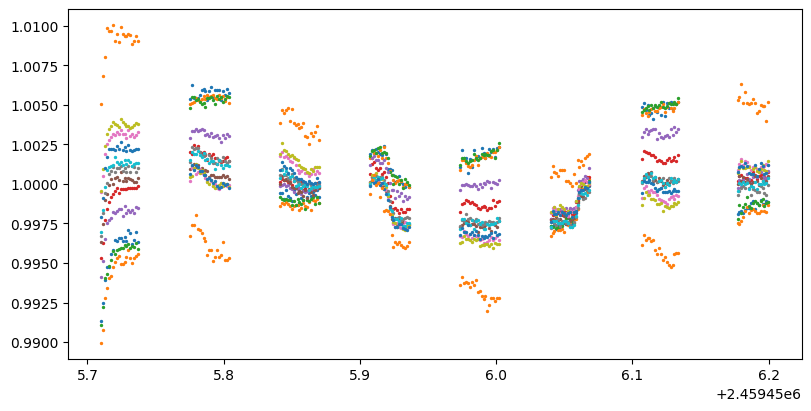

<Figure size 640x480 with 0 Axes>

In [11]:
normalized = trimmed_r

t = normalized.time.value
ramp_profile = rampProfile(result.params,t)
breathing = breathing_effect(result.params,t)

plt.figure(figsize=(8,4))
for j in range(len(trimmed_r.wavelength.value)):
    normalized.flux[j,:] = trimmed_r.flux[j,:]/(ramp_profile*breathing)
    plt.scatter(t,normalized.flux[j,:]/np.nanmedian(normalized.flux[j,:]),s=2)
plt.show()
plt.clf()

normalized.save(f"../data/{visit}_{direction}_normalized_by_linearfit.rainbow.npy")

In [33]:
orbit = np.ones_like(normalized.time.value)
time_in_seconds = normalized.time.value * 24 * 3600

for j in range(len(time_in_seconds)):
    if j >= 1:
        if (time_in_seconds[j] - time_in_seconds[j - 1]) > 1e3:
            orbit[j] = (orbit[j - 1] + 1)
        else:
            orbit[j] = orbit[j - 1]

# print(orbit)

In [13]:
orbit_spectra = {
    'orbit_1':{},
    'orbit_2':{},
    'orbit_3':{},
    'orbit_4':{},
    'orbit_5':{},
    'orbit_6':{},
    'orbit_7':{},
    'orbit_8':{} }

for o in [1, 2, 3, 4, 5, 6, 7, 8]:
    this_orbit_times = normalized.time.value[orbit == o]
    this_orbit_fluxes = normalized.flux[:,orbit == o]
    this_orbit_errors = np.sqrt(normalized.flux[:,orbit == o])
    
    orbit_spectra[f'orbit_{o}']['time'] = this_orbit_times
    orbit_spectra[f'orbit_{o}']['flux'] = this_orbit_fluxes
    orbit_spectra[f'orbit_{o}']['err'] = this_orbit_errors

o = 3
this_orbit_times = orbit_spectra[f'orbit_{o}']['time']
this_orbit_fluxes = orbit_spectra[f'orbit_{o}']['flux']
this_orbit_errors = orbit_spectra[f'orbit_{o}']['err']
mid_transit_flux = orbit_spectra['orbit_5']['flux']
mid_transit_times = orbit_spectra['orbit_5']['time']

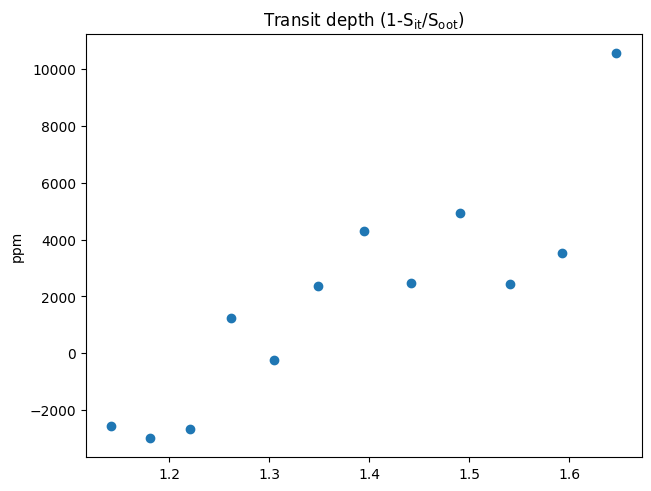

<Figure size 640x480 with 0 Axes>

In [23]:
w = normalized.wavelength.value
#Transit depth comparison
plt.figure()
plt.title(r'Transit depth (1-S$_{\rm it}$/S$_{\rm oot}$)')
plt.scatter(w, (1 - np.nanmedian(mid_transit_flux,axis=1) / np.nanmedian(this_orbit_fluxes,axis=1) )* 1e6)
# plt.scatter(w, median_transit_flux)
plt.ylabel('ppm')
plt.show();plt.clf()